In [1]:
%pylab inline
import pandas as pd 
import os
import json 
import networkx as nx 
import seaborn as sns

from datetime import datetime
from dateutil.parser import parse
from collections import Counter
import operator

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
range(2)

range(0, 2)

# Computation of Evolving weights 
Data : proximity contacts data
- Definition of the algorithm of computation of weights
- Processing of the data 
- Defining parameters
- Running the algorithm on the processed data for different values of the parameters
- Extracting and plotting weights evolution for a sample 

# FUNCTION DEFINITION
Inputs: 
- contacts data 
- parameters of the model 
- Final time resolution (expressed in hours), i.e. setting the timestamps
- Starting time of the perturbation (index of timestamp)
- Ending time of the perturbation (index of timestamp)
- Dictionary with the rule for the perturbation: individuals to be switched

In [3]:
# PERTURBATIONS short durations, with n_hours timespan, choosing t_switch and reswitch based on the timespan 
def evolution_perturbed_weights(contacts,alpha,beta,n_hours,t0,t1,d_switch,d_reswitch):
    
    # Set max value for the weights
    wmax = 1
    
    # Define nodes starting from interacting individuals
    nodes = set(contacts.i.unique()).union(set(contacts.j.unique()))
    N = len(nodes)
    
    
    
    dates = sorted(contacts.Date.unique())
    
    contacts['timespan'] = contacts['interval'].map(lambda x: x//(180*n_hours)+1) 
    
    #Times of start and end of the perturbation expressed in index of the 20s interval 
    t_switch = contacts[contacts['timespan'] == contacts.timespan.unique()[t0]].iloc[0]['interval']

    t_reswitch = contacts[contacts['timespan'] == contacts.timespan.unique()[t1]].iloc[0]['interval']


    #generate a dictionary of complete directed graphs, one for each time interval of 20seconds
    G_p = {}

    # generate another dictionary of graphs that saves the graph at the end of each day
    g_p = {}

    #inizialize the time
    curr_timespan = contacts.timespan.unique()[0]


    #inizialize weigths (at zero)
    G_p[0] = nx.complete_graph(nodes, nx.DiGraph())

    for source, target in G_p[0].edges():
        G_p[0][source][target]['weight'] = 0


    # loop on the single 20s intervals, i.e. resolution of the contacts data 
    for interval in range(len(contacts.interval.unique())):

        t = contacts.interval.unique()[interval]

        # PERTURBATION
        ##########################################################################
        if t == t_switch:

            print(t_switch)
            print(contacts[contacts['interval']==t].iloc[0]['Date'])

            contacts['i'] = contacts.i.apply(lambda x : d_switch[x] if x in d_switch else x)
            contacts['j'] = contacts.j.apply(lambda x : d_switch[x] if x in d_switch else x)




        if t == t_reswitch:

            print(t_reswitch)
            print(contacts[contacts['interval']==t].iloc[0]['Date'])

            contacts['i'] = contacts.i.apply(lambda x : d_reswitch[x] if x in d_reswitch else x)
            contacts['j'] = contacts.j.apply(lambda x : d_reswitch[x] if x in d_reswitch else x)
        #############################################################################


        # define the precedent t
        if interval == 0:
            t_prec = 0
        else:
            t_prec = contacts.interval.unique()[interval-1]

        # select interval 
        contacts_i = contacts[contacts['interval'] == t]
        
        # INSTANTANEOUS NETWORK
        #############################################################################

        '''
        We define an instantaneous network including just the interacting nodes.
        The links of this instantaneous network have to be excluded from the updating of the weights.
        The rule of updating of the weights assumes that we can define the temporal succession 
        of the interactions.
        Since these interactions happen at the same times, the rule would be ambiguous.
        '''
 
        # temporary nodes
        nodes_t = set(contacts_i.i.unique()).union(set(contacts_i.j.unique()))

        # temporary undirected network  
        G_i = nx.from_pandas_edgelist(contacts_i,'i','j')
        ##############################################################################
        
        # for each interval, form a directed network
        G_p[t] = nx.complete_graph(nodes, nx.DiGraph())

        # update weights with the precedent 
        for source, target in G_p[t].edges():
            G_p[t][source][target]['weight'] = G_p[t_prec][source][target]['weight']

        #Check if the timespan has changed
        #At the end of the timespan, save current weights
        if len(contacts_i) == 1:
            timespan = contacts_i.timespan.item()
        else: #len(contacts_i) > 1:
            timespan = contacts_i.timespan.iloc[0]


        if timespan != curr_timespan:
            print(timespan, curr_timespan)
            g_p[curr_timespan] = G_p[t]
            curr_timespan = timespan

        # update weights of g[t], reinforcement for interacting nodes 
        for i in G_i.nodes():
            for j in G_i.neighbors(i):
                G_p[t][i][j]['weight']=G_p[t][i][j]['weight'] + alpha*(wmax - G_p[t][i][j]['weight'])


            #update weights of g[t], decay for non-interacting nodes
            for k in G_p[t].neighbors(i):
                if k in G_i.neighbors(i):
                    continue
                G_p[t][i][k]['weight'] = G_p[t][i][k]['weight']*(1 - beta)  
        #last day 
        if t == contacts.interval.unique()[-1]:  
            g_p[curr_timespan] = G_p[t]

    return g_p

# DATA PROCESSING

In [4]:
#convert to datetime
from time import strftime, localtime

def convert_epoch_to_local(epoch):
    '''Converting epoch to local time'''
    return strftime('%Y-%m-%d %H:%M:%S', localtime(epoch))

check = convert_epoch_to_local(1529496380)
print(check), type(check)

2018-06-20 07:06:20


(None, str)

In [5]:
#DICTIONARY OF NAMES-TAGS after June 11 2019  

f = open('Data/dictionary_tags_names_june_11_2019.json')
tags_to_names = json.load(f)
print(tags_to_names)
names_to_tags = {}
for tag in tags_to_names:
    name = (tags_to_names[tag]) 
    names_to_tags[name] = int(tag)
print(names_to_tags)


#CHANGE KEYS IN INT 
for k in tags_to_names.copy():  #Aquí marcaba error y lo corregí con el .copy()
    tags_to_names[int(k)] = tags_to_names.pop(k)


{'1480': 'VIOLETTE', '1872': 'ANGELE', '1046': 'KALI', '1712': 'FELIPE', '1438': 'BOBO', '1057': 'ARIELLE', '1435': 'EWINE', '1069': 'FANA', '1838': 'PIPO', '1520': 'FEYA', '1522': 'ATMOSPHERE', '1723': 'PETOULETTE', '1789': 'HARLEM'}
{'VIOLETTE': 1480, 'ANGELE': 1872, 'KALI': 1046, 'FELIPE': 1712, 'BOBO': 1438, 'ARIELLE': 1057, 'EWINE': 1435, 'FANA': 1069, 'PIPO': 1838, 'FEYA': 1520, 'ATMOSPHERE': 1522, 'PETOULETTE': 1723, 'HARLEM': 1789}


In [6]:
tags_to_names

{1480: 'VIOLETTE',
 1872: 'ANGELE',
 1046: 'KALI',
 1712: 'FELIPE',
 1438: 'BOBO',
 1057: 'ARIELLE',
 1435: 'EWINE',
 1069: 'FANA',
 1838: 'PIPO',
 1520: 'FEYA',
 1522: 'ATMOSPHERE',
 1723: 'PETOULETTE',
 1789: 'HARLEM'}

In [8]:

FILES = os.listdir(PATH)
FILES

['contacts_20s_2019_Jul_01_pwr1.csv',
 'contacts_20s_2019_Jul_02_pwr1.csv',
 'contacts_20s_2019_Jul_03_pwr1.csv',
 'contacts_20s_2019_Jul_04_pwr1.csv',
 'contacts_20s_2019_Jul_05_pwr1.csv',
 'contacts_20s_2019_Jul_08_pwr1.csv',
 'contacts_20s_2019_Jul_09_pwr1.csv',
 'contacts_20s_2019_Jul_10_pwr1.csv',
 'contacts_20s_2019_Jun_13_pwr1.csv',
 'contacts_20s_2019_Jun_14_pwr1.csv',
 'contacts_20s_2019_Jun_17_pwr1.csv',
 'contacts_20s_2019_Jun_18_pwr1.csv',
 'contacts_20s_2019_Jun_19_pwr1.csv',
 'contacts_20s_2019_Jun_20_pwr1.csv',
 'contacts_20s_2019_Jun_21_pwr1.csv',
 'contacts_20s_2019_Jun_24_pwr1.csv',
 'contacts_20s_2019_Jun_25_pwr1.csv',
 'contacts_20s_2019_Jun_26_pwr1.csv',
 'contacts_20s_2019_Jun_27_pwr1.csv',
 'contacts_20s_2019_Jun_28_pwr1.csv',
 'data']

In [11]:
#CHOOSE FILES

PATH = 'Data/Contacts/'
FILES = os.listdir(PATH)

#Import contacts and merge contacts of all the contacts files 

list_df = []
for el in FILES:
    
    filename = PATH+el

    df_rfid = pd.read_csv(filename, compression = None, index_col = False,sep = ' ',names=['t','i','j'])
    df_rfid = df_rfid[(df_rfid['i'].isin(tags_to_names)) & (df_rfid['j'].isin(tags_to_names))]
    
    
    df_rfid['DateTime'] = df_rfid['t'].map(lambda x: convert_epoch_to_local(x))
    df_rfid['DateTime'] = pd.to_datetime(df_rfid['DateTime'])
    df_rfid.sort_values('DateTime')
    df_rfid['Date'] = df_rfid['DateTime'].map(lambda x: datetime.strftime(x, '%Y-%m-%d'))
    list_df.append(df_rfid)

contacts = pd.concat(list_df)
contacts = contacts.sort_values('DateTime')

# DIVIDE THE CONTACTS IN TIME WINDOWS OF 20 SECONDS AND ASSIGN THE APPROPRIATE INDEX TO EACH CONTACT 
t0 = contacts.iloc[0]['t']
t_end = contacts.iloc[-1]['t']


contacts['interval'] = contacts.t.map(lambda x: (x-t0)//20+1)
contacts.head()

,t,i,j,DateTime,Date,interval
0,1560396500,1057,1069,2019-06-12 22:28:20,2019-06-12,1
1,1560396500,1057,1480,2019-06-12 22:28:20,2019-06-12,1
2,1560396520,1069,1789,2019-06-12 22:28:40,2019-06-12,2
3,1560396540,1712,1872,2019-06-12 22:29:00,2019-06-12,3
4,1560396540,1057,1069,2019-06-12 22:29:00,2019-06-12,3


In [12]:
# CHOOSE A DAY AND SET THE TIME RESOLUTION
day = '2019-06-25'
#contacts = pd.concat(list_df)
#contacts = contacts.sort_values('DateTime')
contacts_ = contacts[contacts['Date'] == day]
t0 = contacts_.iloc[0]['t']
#contacts_['interval'] = contacts_.t.map(lambda x: (x-t0)//20+1)
contacts_.head()

,t,i,j,DateTime,Date,interval
367,1561438800,1438,1838,2019-06-25 00:00:00,2019-06-25,52116
368,1561438800,1712,1838,2019-06-25 00:00:00,2019-06-25,52116
369,1561438820,1046,1069,2019-06-25 00:00:20,2019-06-25,52117
370,1561438880,1712,1838,2019-06-25 00:01:20,2019-06-25,52120
371,1561438880,1057,1872,2019-06-25 00:01:20,2019-06-25,52120


# INPUT SETTING

In [13]:

ind1 = 1712
ind2 = 1789

d_switch = {ind1 : ind2, ind2 : ind1}
d_reswitch = {ind1 : ind2, ind2 : ind1}

tp0 = 6
tp1 = 10 

alpha = 0.1
beta1=alpha*10
beta2=alpha*5
beta3 = alpha*2
n_hours = 0.5

# ANALYSIS

In [14]:
# Run the algorithm on the data 
g = evolution_perturbed_weights(contacts_, alpha, alpha, n_hours, tp0, tp1, d_switch, d_reswitch)
g1 = evolution_perturbed_weights(contacts_, alpha,beta1, n_hours, tp0, tp1, d_switch, d_reswitch)
g2 = evolution_perturbed_weights(contacts_, alpha,beta2, n_hours, tp0, tp1, d_switch, d_reswitch)
g3 = evolution_perturbed_weights(contacts_, alpha,beta3, n_hours, tp0, tp1, d_switch, d_reswitch)

C:\Users\jgeis\AppData\Local\Temp\ipykernel_7756\1124263500.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contacts['timespan'] = contacts['interval'].map(lambda x: x//(180*n_hours)+1)


581.0 580.0
582.0 581.0
583.0 582.0
584.0 583.0
585.0 584.0
52685
2019-06-25
586.0 585.0


C:\Users\jgeis\AppData\Local\Temp\ipykernel_7756\1124263500.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contacts['i'] = contacts.i.apply(lambda x : d_switch[x] if x in d_switch else x)
C:\Users\jgeis\AppData\Local\Temp\ipykernel_7756\1124263500.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contacts['j'] = contacts.j.apply(lambda x : d_switch[x] if x in d_switch else x)


587.0 586.0
588.0 587.0
589.0 588.0
53010
2019-06-25
590.0 589.0


C:\Users\jgeis\AppData\Local\Temp\ipykernel_7756\1124263500.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contacts['i'] = contacts.i.apply(lambda x : d_reswitch[x] if x in d_reswitch else x)
C:\Users\jgeis\AppData\Local\Temp\ipykernel_7756\1124263500.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contacts['j'] = contacts.j.apply(lambda x : d_reswitch[x] if x in d_reswitch else x)


591.0 590.0
592.0 591.0
593.0 592.0
594.0 593.0
595.0 594.0
596.0 595.0
597.0 596.0
598.0 597.0
599.0 598.0
600.0 599.0
601.0 600.0
602.0 601.0
603.0 602.0
604.0 603.0
605.0 604.0
606.0 605.0
607.0 606.0
608.0 607.0
609.0 608.0
610.0 609.0
625.0 610.0
626.0 625.0
627.0 626.0
628.0 627.0
581.0 580.0
582.0 581.0
583.0 582.0
584.0 583.0
585.0 584.0
52685
2019-06-25
586.0 585.0
587.0 586.0
588.0 587.0
589.0 588.0
53010
2019-06-25
590.0 589.0
591.0 590.0
592.0 591.0
593.0 592.0
594.0 593.0
595.0 594.0
596.0 595.0
597.0 596.0
598.0 597.0
599.0 598.0
600.0 599.0
601.0 600.0
602.0 601.0
603.0 602.0
604.0 603.0
605.0 604.0
606.0 605.0
607.0 606.0
608.0 607.0
609.0 608.0
610.0 609.0
625.0 610.0
626.0 625.0
627.0 626.0
628.0 627.0
581.0 580.0
582.0 581.0
583.0 582.0
584.0 583.0
585.0 584.0
52685
2019-06-25
586.0 585.0
587.0 586.0
588.0 587.0
589.0 588.0
53010
2019-06-25
590.0 589.0
591.0 590.0
592.0 591.0
593.0 592.0
594.0 593.0
595.0 594.0
596.0 595.0
597.0 596.0
598.0 597.0
599.0 598.0
600.0 59

In [15]:
listtimes = sorted(g.keys())
edges = g[listtimes[0]].edges()
weights = {}
weights1= {}
weights2 = {}
weights3 = {}
for e in edges:
    weights[e] = []
    weights1[e] = []
    weights2[e] = []
    weights3[e] = []
    for t in listtimes:
        weights[e].append(g[t][e[0]][e[1]]['weight'])
        weights1[e].append(g1[t][e[0]][e[1]]['weight'])
        weights2[e].append(g2[t][e[0]][e[1]]['weight'])
        weights3[e].append(g3[t][e[0]][e[1]]['weight'])

In [12]:
weights

{(1480, 1872.0): [0.0,
  0.11219310000000002,
  0.043465905664425916,
  0.3590556241846058,
  0.14754330346483818,
  0.10755906822586704,
  0.09680316140328034,
  0.0273400720050239,
  0.0015898179967363194,
  0.07351592806571661,
  0.05359311155990741,
  0.09723963468061414,
  0.03390536413633041,
  0.018018700621975574,
  0.013135632753420196,
  0.010639862530270359,
  0.005089013264654469,
  0.0019715880075199216,
  0.09061870520788373,
  0.04334264578294465,
  0.03900838120465019,
  0.01360138150926359,
  0.006505498611598096,
  0.0031115598188816737,
  0.0009764404415329508,
  0.00034046373000426466,
  1.1690448011120826e-05,
  0.047830051271719694,
  0.0025031744120631804,
  0.0002465053324090391,
  0.1811617321485936,
  0.16304555893373424,
  0.10009140411661581,
  0.047873408305624594,
  0.047873408305624594],
 (1480, 1046): [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.32414410000000005,
  0.396580065728465,


In [16]:
#choose the strongest links, i.e. links with the average highest weight or select a set of links
avg_weights = {l: np.mean(weights[l]) for l in weights}
max_weights = {l: max(weights[l]) for l in weights}
ranking  = sorted(max_weights.items(), key=operator.itemgetter(1), reverse=True)

In [17]:
filtered_set_ranked = [w[0] for w in ranking]

In [18]:
filtered_set = [
    (1522, 1712),
    (1712, 1522),
    (1789, 1522),
    (1522, 1789),
    (1789, 1872),
    (1480, 1789),
    (1712, 1872),
    (1872, 1789),
    (1069, 1712),
    (1435, 1712),
    (1435, 1789),
    (1057, 1712),
    (1789, 1435),
    (1712, 1057),
    (1789, 1480),
    (1712, 1520),
    (1872, 1712),
    (1520, 1712),
    (1712, 1435),
    (1712, 1069),
]

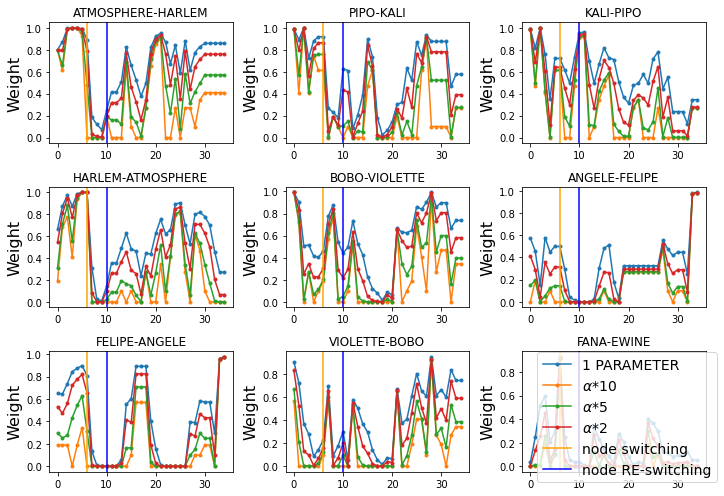

In [19]:
# TRAJECTORIES OF SINGLE WEIGHTS
fig = plt.figure(figsize=(10,7))
i=1
                 
for edge in filtered_set_ranked[:9]:
    ax = fig.add_subplot(3,3,i)
    if i==9:
        ax.plot(weights[edge], '.-', label='1 PARAMETER') 
        ax.plot(weights1[edge], '.-', label=r'$\alpha$*10' ) 
        ax.plot(weights2[edge], '.-', label=r'$\alpha$*5') 
        ax.plot(weights3[edge], '.-', label=r'$\alpha$*2')
        plt.axvline(x=tp0, color='orange', label='node switching')
        plt.axvline(x=tp1, color='blue', label='node RE-switching')
    else:
        ax.plot(weights[edge], '.-')
        ax.plot(weights1[edge], '.-')
        ax.plot(weights2[edge], '.-')
        ax.plot(weights3[edge], '.-')
        
        plt.axvline(x=tp0, color='orange')
        plt.axvline(x=tp1, color='blue')
   

    plt.ylabel('Weight', fontsize=16)
    ax.set_title(tags_to_names[edge[0]]+'-'+tags_to_names[edge[1]])
    plt.tight_layout()
    i+=1
    
lgd = plt.legend(loc=1, prop={'size': 14}, bbox_to_anchor=(1.1, 1.05))
FILEPATH = 'Figures/'
FILENAME = 'TEMPORARY_Perturbed_'+str(n_hours)+'_timespan_switched_'+str(ind1)+'_'+str(ind2)+'_t_switch_'+str(tp0)+'_'+str(tp1)+'_'+str(day)+'_alpha_'+str(alpha)+'.png'

#plt.savefig(FILEPATH+FILENAME, dpi=150)
plt.show()

# GCS MATRICES

In [20]:
def cosine_sim(A,B):
    norm_A = math.sqrt(sum([x**2 for x in A]))
    norm_B = math.sqrt(sum([x**2 for x in B]))
    return np.dot(A,B)/(norm_A*norm_B)


def cosine_sim_graph_out(i,g1,g2):
    if i in g1.nodes() and i in g2.nodes():
        neigh1 = set(g1.neighbors(i))
        neigh2 = set(g2.neighbors(i))
      #  print(neigh1,neigh2)
        norm1 = math.sqrt(sum([g1.get_edge_data(i,j)['weight']**2 for j in neigh1]))
        norm2 = math.sqrt(sum([g2.get_edge_data(i,j)['weight']**2 for j in neigh2]))
        numerator = sum([g1.get_edge_data(i,j)['weight']*g2.get_edge_data(i,j)['weight'] 
                         for j in neigh1.intersection(neigh2)])
    else:
        norm1, norm2, numerator = 1, 1, 0
    return numerator/(norm1*norm2)

def cosine_sim_graph_in(i,g1,g2):
    if i in g1.nodes() and i in g2.nodes():
        neigh1 = set(g1.neighbors(i))
        neigh2 = set(g2.neighbors(i))
      #  print(neigh1,neigh2)
        norm1 = math.sqrt(sum([g1.get_edge_data(j,i)['weight']**2 for j in neigh1]))
        norm2 = math.sqrt(sum([g2.get_edge_data(j,i)['weight']**2 for j in neigh2]))
        numerator = sum([g1.get_edge_data(j,i)['weight']*g2.get_edge_data(j,i)['weight'] 
                         for j in neigh1.intersection(neigh2)])
    else:
        norm1, norm2, numerator = 1, 1, 0
    return numerator/(norm1*norm2)
    
    


In [21]:
# Global cosine similarity 
gcs = {}

listtimes = sorted(g.keys())

for t1 in listtimes:
    for t2 in listtimes:
        #if t1>=t2:
        #    continue
        list_w1 = []
        list_w2 = []
        
        g1 = g[t1]
        g2 = g[t2]
        
        setnodes1 = set(g1.nodes())
        setnodes2 = set(g2.nodes())
        setnodes = setnodes1.union(setnodes2)
        
        edges = set(g1.edges()).intersection(set(g2.edges()))
        for i,j in edges:
            list_w1.append(g1.get_edge_data(i,j)['weight'])
            list_w2.append(g2.get_edge_data(i,j)['weight'])
        
        gcs[(t1,t2)] = cosine_sim(list_w1,list_w2)

In [22]:
 #Esto tiene caracteres prohibidos
beta_meth=str(beta)
characters = "'>< .-"

beta_meth = ''.join( x for x in beta_meth if x not in characters)
print(beta_meth)

builtinmethodbetaofnumpyrandommtrandRandomStateobjectat0x000001C88C2D5840


In [23]:
'../GCS_VALUES_2_PARAMETERS_TEMPORARY_Perturbed_'+str(n_hours)+'_timespan_switched_'+str(ind1)+'_'+str(ind2)+'_t_switch_'+str(tp0)+'_'+str(tp1)+'_'+str(day)+'_alpha_'+str(alpha)+'_beta_'+str(beta)+'_BABOONS_DATA'

'../GCS_VALUES_2_PARAMETERS_TEMPORARY_Perturbed_0.5_timespan_switched_1712_1789_t_switch_6_10_2019-06-25_alpha_0.1_beta_<built-in method beta of numpy.random.mtrand.RandomState object at 0x000001C88C2D5840>_BABOONS_DATA'

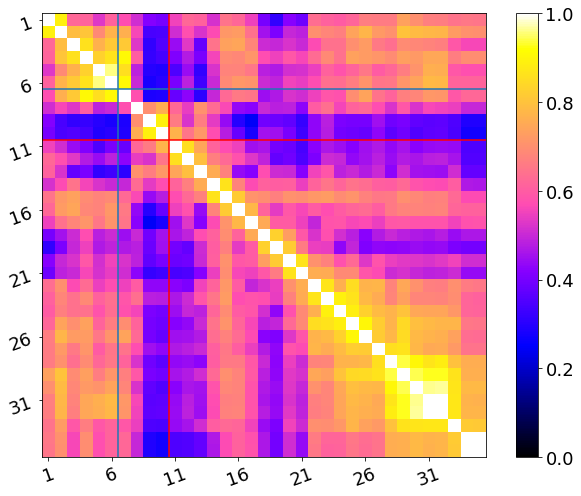

In [24]:
listtimes = sorted(g.keys())

#COMPUTE THE MATRIX

arraygcs = []
for t1 in listtimes:
    arraygcs.append([gcs[(t1,t2)] for t2 in listtimes])

arraygcs = np.array(arraygcs)
#np.save('../GCS_VALUES_2_PARAMETERS_TEMPORARY_Perturbed_'+str(n_hours)+'_timespan_switched_'+str(ind1)+'_'+str(ind2)+'_t_switch_'+str(tp0)+'_'+str(tp1)+'_'+str(day)+'_alpha_'+str(alpha)+'_beta_'+str(beta)+'_BABOONS_DATA', arraygcs)
#Esta linea de arriba la tuve que sustituir por:
 #Esto tiene caracteres prohibidos
beta_meth=str(beta)
characters = "'>< .-"

beta_meth = ''.join( x for x in beta_meth if x not in characters)
np.save('../GCS_VALUES_2_PARAMETERS_TEMPORARY_Perturbed_'+str(n_hours)+'_timespan_switched_'+str(ind1)+'_'+str(ind2)+'_t_switch_'+str(tp0)+'_'+str(tp1)+'_'+str(day)+'_alpha_'+str(alpha)+'_beta_'+beta_meth+'_BABOONS_DATA', arraygcs)

#Hasta la línea de arriba es lo que se modificó 25042022
fig, ax = plt.subplots(figsize=(9,7))

# VISUALIZATION AND LIMITS

cmapProp = {'drawedges': False,}
m = ax.imshow(arraygcs, cmap=plt.cm.get_cmap('gnuplot2'), vmin=0, vmax=1)
cbar = ax.figure.colorbar(m, ax=ax, **cmapProp)
cbar.ax.tick_params(labelsize=18) 


ax.hlines([tp0-0.5], *ax.get_xlim())
ax.vlines([tp0-0.5], *ax.get_xlim())


ax.hlines([tp1-0.5], *ax.get_xlim(), color='red')
ax.vlines([tp1-0.5], *ax.get_xlim(), color='red')

ax.set_yticks(range(len(listtimes))[::5])
ax.set_yticklabels(range(1,len(listtimes)+1)[::5],rotation=20, fontsize=18)

ax.set_xticks(range(len(listtimes))[::5])
ax.set_xticklabels(range(1,len(listtimes)+1)[::5],rotation=20, fontsize=18)


plt.tight_layout()

FILEPATH = 'Figures/'
FILENAME = 'GCS_MATRIX_Perturbed_'+str(n_hours)+'_timespan_switched_'+str(ind1)+'_'+str(ind2)+'_t_switch_'+str(tp0)+'_'+str(tp1)+'_'+str(day)+'_alpha_'+str(alpha)+'_beta_'+beta_meth+'_BABOONS_DATA.png'
#OJO; en la línea de arriba también sustituí str(beta) por beta_meth

characters = "'>< .-"

FILENAME = ''.join( x for x in FILENAME if x not in characters)
FILENAME

plt.savefig(FILEPATH+FILENAME)
plt.show()